In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
precip = pd.read_table("monthly_precip.txt", index_col=0, na_values='NA', delim_whitespace=True) 
precip.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
Year,,,,,,,,,,,,
1912,0.72,0.84,1.05,0.79,4.21,1.46,6.54,3.51,4.00,1.76,0.70,2.00
1913,0.97,0.42,2.87,1.41,7.40,4.15,9.55,1.99,3.82,3.23,2.05,0.22
1914,0.87,0.47,1.39,2.75,6.41,3.27,2.93,3.44,4.19,2.81,0.71,0.94
1915,1.45,2.05,0.45,0.25,4.05,1.43,3.83,3.80,6.05,0.86,2.65,0.21
1916,2.45,0.45,1.54,1.99,3.39,4.82,0.02,3.76,7.64,3.64,1.12,0.82


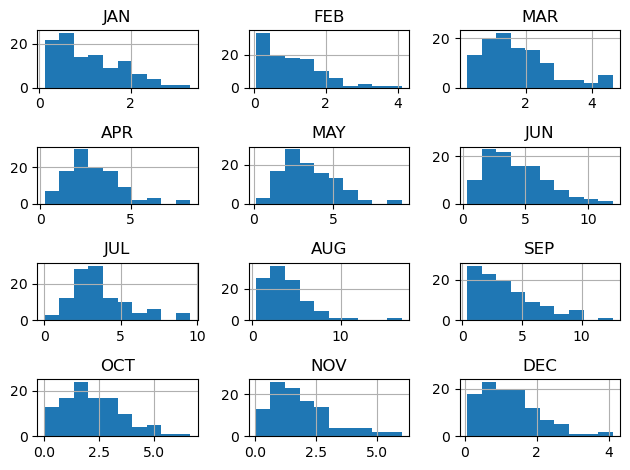

In [54]:
precip.hist(grid = True)
plt.tight_layout()

In [53]:
precip.describe()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,1.072294,1.038349,1.744679,2.896422,3.464495,4.215046,3.647431,3.744037,3.691835,2.268991,1.892569,1.271835
std,0.691470,0.781886,1.024987,1.446926,1.708982,2.343284,1.907703,2.422342,2.533615,1.349876,1.257030,0.817423
min,0.120000,0.050000,0.230000,0.250000,0.130000,0.360000,0.020000,0.420000,0.400000,0.040000,0.050000,0.070000
25%,0.530000,0.430000,1.010000,2.000000,2.280000,2.280000,2.400000,2.120000,1.630000,1.290000,1.030000,0.710000
50%,0.870000,0.880000,1.540000,2.640000,3.160000,3.790000,3.260000,3.370000,3.070000,2.090000,1.600000,1.200000
75%,1.590000,1.430000,2.330000,3.660000,4.310000,5.670000,4.460000,4.620000,5.020000,3.120000,2.470000,1.690000
max,3.300000,4.110000,4.620000,8.310000,9.330000,11.970000,9.550000,16.910000,12.590000,6.670000,5.980000,4.110000


### Maximum Likelihood Estimation

In [14]:
from scipy.optimize import newton

In [15]:
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [16]:
# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

In [64]:
# Alpha MLE
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

2.1911076661111086

In [65]:
# Beta MLE
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

1.722792581736355

In [19]:
precip_mean = precip.mean()
precip_mean

precip_var = precip.var()
precip_var

alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean
alpha_mom, beta_mom

(JAN    2.404810
 FEB    1.763599
 MAR    2.897303
 APR    4.007107
 MAY    4.109652
 JUN    3.235600
 JUL    3.655548
 AUG    2.388961
 SEP    2.123261
 OCT    2.825384
 NOV    2.266794
 DEC    2.420851
 dtype: float64,
 JAN    0.445895
 FEB    0.588767
 MAR    0.602173
 APR    0.722821
 MAY    0.843014
 JUN    1.302709
 JUL    0.997780
 AUG    1.567224
 SEP    1.738757
 OCT    0.803074
 NOV    0.834910
 DEC    0.525367
 dtype: float64)

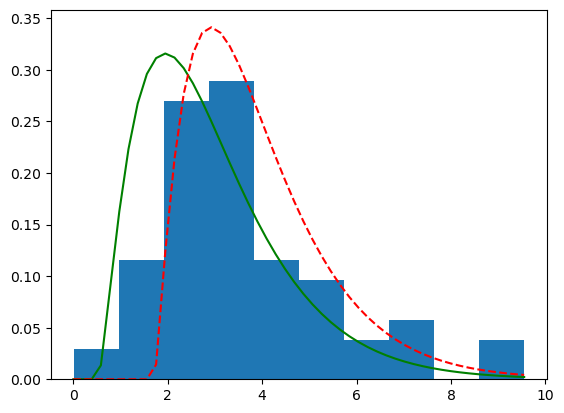

In [74]:
from scipy.stats.distributions import gamma

jul = precip.JUL
jul.hist(density=True, bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'g-')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

### Bayesian Simulation 

In [66]:
from pymc3 import Model, Uniform , Normal , StudentT

with Model() as rain_model:
    μ_0 = Normal('μ_0', 3.5, sd=1.25)
    μ_1 = Normal('μ_1', 3.5, sd=1.25)

In [67]:
with rain_model:
    σ_0 = Uniform('σ_0', lower=0, upper=2.5)
    σ_1 = Uniform('σ_1', lower=0, upper=2.5)

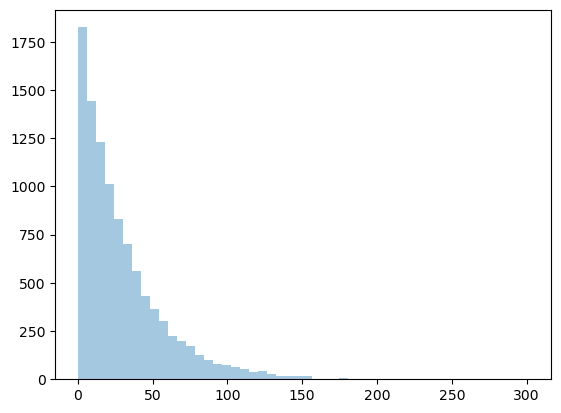

In [68]:
from pymc3 import Exponential
import seaborn as sns

sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);

In [69]:
with rain_model:
    ν = Exponential('ν_minus_log', 1/29.) + 1

In [70]:
with rain_model:
    rain_like = StudentT('rain_likes', nu=ν, mu=μ_1, lam=σ_1**2, observed=precip.JUL)

In [71]:
from pymc3 import Deterministic

with rain_model:
    diff_of_means = Deterministic('difference_of_means', μ_1 - μ_0)
    effect_size = Deterministic('effect_size', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

In [72]:
from pymc3 import fit
RANDOM_SEED = 20090425

with rain_model: 
    rain_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 228.66


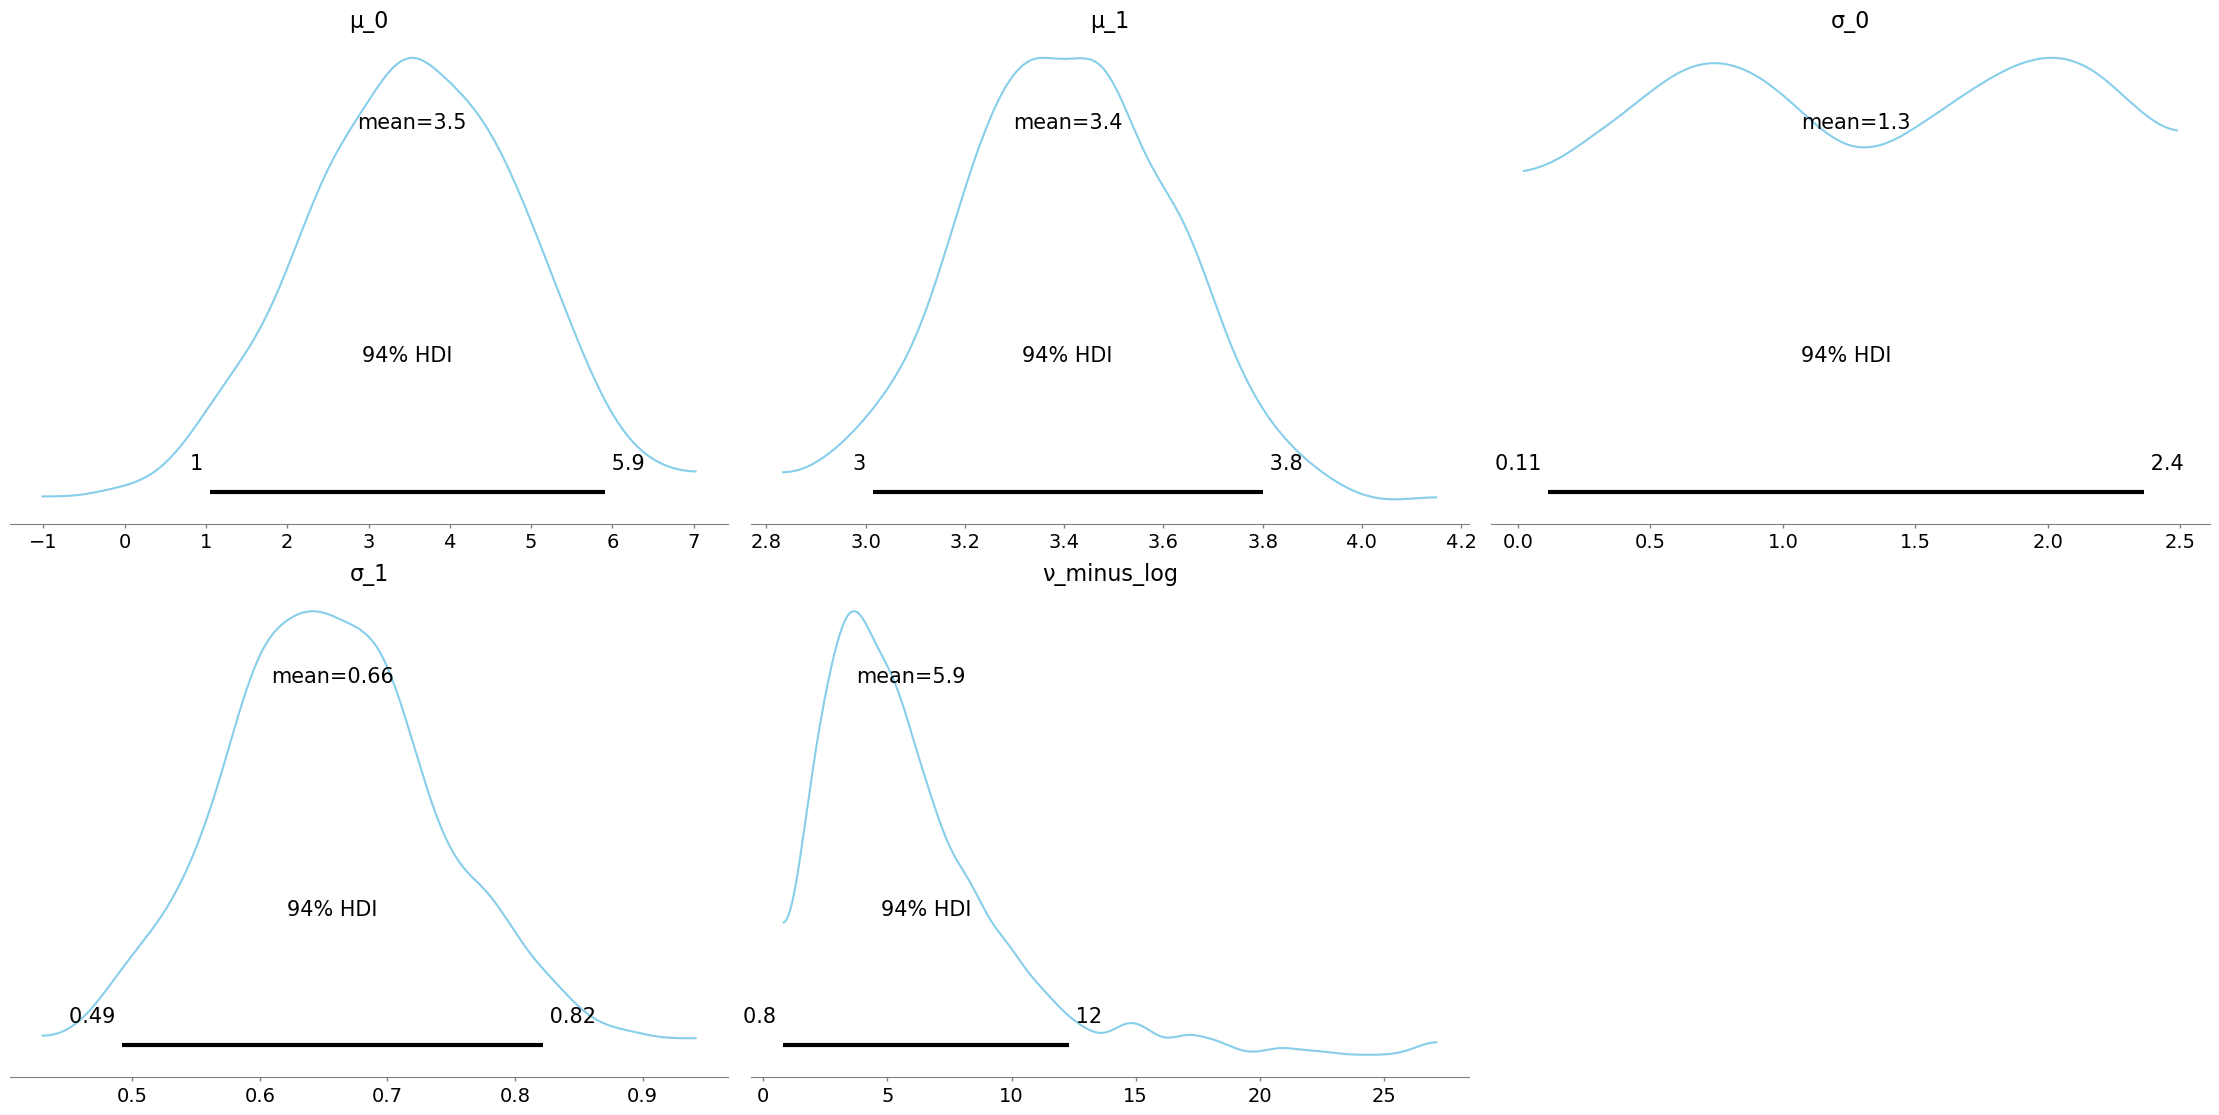

In [73]:
from pymc3 import plot_posterior

plot_posterior(rain_trace[100:], 
                var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_log'],
                color='#87ceeb');

### W

**Note - During the implementation of Maximum Likelihood Estimation (MLE), we discovered that the estimated values for the parameters - namely the mean and standard deviation - were significantly better than the values obtained through the Method of Moments approach, and were also closer to the actual values. On the other hand, when using Bayesian Simulation, we obtained fixed exact values for the means and standard deviations of the parameters, which were found to be even closer to the observed mean and standard deviation of the dataset when compared to MLE.
<br>Overall, it was an enjoyable experience implementing both of these statistical approaches, and we were able to observe the strengths and weaknesses of each method in practice. While MLE is useful when prior knowledge about the parameters is limited and unbiased estimates are desired, Bayesian Simulation can be advantageous when incorporating prior knowledge or accounting for uncertainty about the parameters. Ultimately, the choice between these methods depends on the specific problem at hand and the assumptions that can be made.**